# CONTEÚDO DO FICHEIRO

**Ficheiro**: Neste ficheiro apresentamos um tratamento de dados semelhante ao que foi referido no relatório e no ficheiro 2 (sem normalização), contudo decidiu-se representar a coluna Day em é fim de semana ou nao e criar colunas que representem a altura do dia. Neste ficheiro tentamos fazer o tratamento dos outilers para todas as colunas com valores continuos aproximando-os ao percentil mais próximo. Para a coluna AVERAGE_TIME_DIFF decidimos dividir o dataset de forma semelhante ao que foi feito no ficheiro 3. Para os modelos foram aplicado os mesmos que no ficheiro 4.

# COMPETIÇÃO
O objetivo deste trabalho passa por desenvolver modelos de Machine Learning capaz de prever o fluxo de tráfego rodoviário, numa determinada hora, no Porto.
O modelo a desenvolver terá, na sua base, o tempo que se demora a percorrer as ruas da cidade do Porto num determinado ponto temporal (record_date); na temperatura, pressão atmosférica, humidade, precipitação e velocidade do vento, entre outras, que caracterizam um determinado ponto temporal.
Devem utilizar o modelo desenvolvido para prever, para cada registo do dataset de teste, o nível de trânsito correspondente.


**Resumo:** A partir do dataset de treino modelar o average speed diff de um carro segundo as condições presente nos restantes dados. O average speed diff pode ser None, Low, Medium, High, Very_high isto é, pode não haver trânsito (None) até haver muito trânsito (Very_high). De seguida, aplicar a modelação para determinar quais os valores de average speed diff para cada linha do dataset de teste e enviar uma submissão para determinar a acurácia. 

**Problema supervisionado de classificação**

## IMPORTS

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import sklearn
from sklearn.tree import DecisionTreeClassifier,  DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from scipy.stats.mstats import winsorize
%matplotlib inline

## DATASET
O dataset de treino é constituido pelo os seguintes parâmetros:
- **city_name** - nome da cidade em causa;
- **record_date** - o timestamp associado ao registo;
- **average_speed_diff** - a diferença de velocidade corresponde à diferença entre (1.) a velocidade máxima que os carros podem atingir em cenários sem trânsito e (2.) a velocidade que realmente se verifica. Quanto mais alto o valor, maior é a diferença entre o que se está a andar no momento e o que se deveria estar a andar sem trânsito, i.e., valores altos deste atributo implicam que se está a andar mais devagar;
- **average_free_flow_speed** - o valor médio da velocidade máxima que os carros podem atingir em cenários sem trânsito;
- **average_time_diff** - o valor médio da diferença do tempo que se demora a percorrer um determinado conjunto de ruas. Quanto mais alto o valor maior é a diferença entre o tempo que demora para se percorrer as ruas e o que se deveria demorar sem trânsito, i.e., valores altos implicam que se está a demorar mais tempo a atravessar o conjunto de ruas;
- **average_free_flow_time** - o valor médio do tempo que demora a percorrer um determinado conjunto de ruas quando não há trânsito;
- **luminosity** - o nível de luminosidade que se verificava na cidade do Porto;
- **average_temperature** - o valor médio da temperatura para o record_date na cidade do Porto;
- **average_atmosp_pressure** - o valor médio da pressão atmosférica para o record_date;
- **average_humidity** - o valor médio da humidade para o record_date;
- **average_wind_speed** - o valor médio da velocidade do vento para o record_date;
- **average_cloudiness** - o valor médio da percentagem de nuvens para o record_date;
- **average_precipitation** - o valor médio de precipitação para o record_date;
- **average_rain** - avaliação qualitativa da precipitação para o record_date.

In [2]:
traffic = pd.read_csv('training_data.csv')
test = pd.read_csv('test_data.csv')

In [3]:
traffic.head()

,city_name,record_date,AVERAGE_SPEED_DIFF,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,LUMINOSITY,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_HUMIDITY,AVERAGE_WIND_SPEED,AVERAGE_CLOUDINESS,AVERAGE_PRECIPITATION,AVERAGE_RAIN
0,Porto,2019-08-29 07:00:00,Medium,41.5,11.5,71.4,LIGHT,15.0,1019.0,100.0,3.0,NaN,0.0,NaN
1,Porto,2018-08-10 14:00:00,High,41.7,48.3,87.4,LIGHT,21.0,1021.0,53.0,5.0,céu claro,0.0,NaN
2,Porto,2019-09-01 16:00:00,High,38.6,38.4,85.2,LIGHT,26.0,1014.0,61.0,4.0,NaN,0.0,NaN
3,Porto,2019-02-26 11:00:00,High,37.4,61.0,94.1,LIGHT,18.0,1025.0,48.0,4.0,céu claro,0.0,NaN
4,Porto,2019-06-06 12:00:00,Medium,41.6,50.4,77.0,LIGHT,15.0,1008.0,82.0,10.0,NaN,0.0,NaN


In [4]:
# melhor representação dos dados atendendo aos outliers (moda media mediana)
# deteção de outliers (desvio padrão, vâriancia)
traffic.describe()

,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_HUMIDITY,AVERAGE_WIND_SPEED,AVERAGE_PRECIPITATION
count,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.0
mean,40.661010,25.637111,81.143952,16.193482,1017.388139,80.084190,3.058573,0.0
std,4.119023,33.510507,8.294401,5.163492,5.751061,18.238863,2.138421,0.0
min,30.500000,0.000000,46.400000,0.000000,985.000000,14.000000,0.000000,0.0
25%,37.600000,2.275000,75.400000,13.000000,1015.000000,69.750000,1.000000,0.0
50%,40.700000,12.200000,82.400000,16.000000,1017.000000,83.000000,3.000000,0.0
75%,43.500000,36.200000,87.400000,19.000000,1021.000000,93.000000,4.000000,0.0
max,55.900000,296.500000,112.000000,35.000000,1033.000000,100.000000,14.000000,0.0


In [5]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6812 entries, 0 to 6811
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   city_name                6812 non-null   object 
 1   record_date              6812 non-null   object 
 2   AVERAGE_SPEED_DIFF       6812 non-null   object 
 3   AVERAGE_FREE_FLOW_SPEED  6812 non-null   float64
 4   AVERAGE_TIME_DIFF        6812 non-null   float64
 5   AVERAGE_FREE_FLOW_TIME   6812 non-null   float64
 6   LUMINOSITY               6812 non-null   object 
 7   AVERAGE_TEMPERATURE      6812 non-null   float64
 8   AVERAGE_ATMOSP_PRESSURE  6812 non-null   float64
 9   AVERAGE_HUMIDITY         6812 non-null   float64
 10  AVERAGE_WIND_SPEED       6812 non-null   float64
 11  AVERAGE_CLOUDINESS       4130 non-null   object 
 12  AVERAGE_PRECIPITATION    6812 non-null   float64
 13  AVERAGE_RAIN             563 non-null    object 
dtypes: float64(8), object(6)

In [6]:
traffic['AVERAGE_SPEED_DIFF'].value_counts()

None         2200
Medium       1651
Low          1419
High         1063
Very_High     479
Name: AVERAGE_SPEED_DIFF, dtype: int64

In [7]:
traffic['LUMINOSITY'].value_counts()

LIGHT        3293
DARK         3253
LOW_LIGHT     266
Name: LUMINOSITY, dtype: int64

In [8]:
traffic['AVERAGE_CLOUDINESS'].value_counts()

céu claro            1582
céu pouco nublado     516
nuvens dispersas      459
nuvens quebrados      448
algumas nuvens        422
nuvens quebradas      416
céu limpo             153
tempo nublado          67
nublado                67
Name: AVERAGE_CLOUDINESS, dtype: int64

In [9]:
traffic['AVERAGE_RAIN'].value_counts()

chuva fraca                    261
chuva moderada                 153
chuva leve                      45
aguaceiros fracos               38
chuva                           30
aguaceiros                      11
chuva forte                      8
trovoada com chuva leve          7
chuvisco fraco                   5
chuva de intensidade pesado      2
chuva de intensidade pesada      1
trovoada com chuva               1
chuvisco e chuva fraca           1
Name: AVERAGE_RAIN, dtype: int64

In [10]:
print(traffic.isna().sum()) # Contagem dos valores em falta do dataset 

city_name                     0
record_date                   0
AVERAGE_SPEED_DIFF            0
AVERAGE_FREE_FLOW_SPEED       0
AVERAGE_TIME_DIFF             0
AVERAGE_FREE_FLOW_TIME        0
LUMINOSITY                    0
AVERAGE_TEMPERATURE           0
AVERAGE_ATMOSP_PRESSURE       0
AVERAGE_HUMIDITY              0
AVERAGE_WIND_SPEED            0
AVERAGE_CLOUDINESS         2682
AVERAGE_PRECIPITATION         0
AVERAGE_RAIN               6249
dtype: int64


In [11]:
print(traffic[traffic.duplicated()]) # Verifica se e quais são os valores duplicados

Empty DataFrame
Columns: [city_name, record_date, AVERAGE_SPEED_DIFF, AVERAGE_FREE_FLOW_SPEED, AVERAGE_TIME_DIFF, AVERAGE_FREE_FLOW_TIME, LUMINOSITY, AVERAGE_TEMPERATURE, AVERAGE_ATMOSP_PRESSURE, AVERAGE_HUMIDITY, AVERAGE_WIND_SPEED, AVERAGE_CLOUDINESS, AVERAGE_PRECIPITATION, AVERAGE_RAIN]
Index: []


In [12]:
aux =  traffic.loc[traffic.AVERAGE_TIME_DIFF > 50, "AVERAGE_TIME_DIFF"]
aux.count()

1173

## Vizualização dos dados

In [13]:
sns.set_theme(palette="pastel")

<AxesSubplot:>

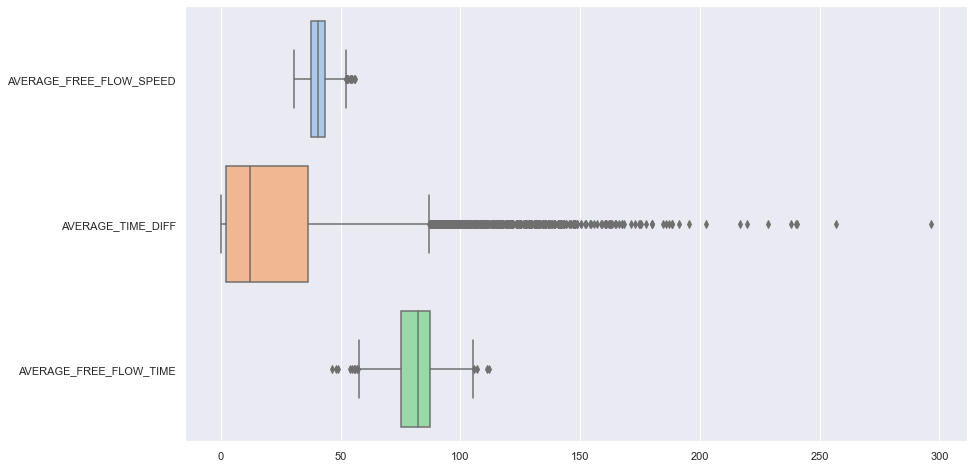

In [14]:
traffic_aux = traffic.drop(['city_name','record_date','AVERAGE_SPEED_DIFF','LUMINOSITY', 'AVERAGE_CLOUDINESS', 
                            'AVERAGE_RAIN', 'AVERAGE_PRECIPITATION', 'AVERAGE_TEMPERATURE', 'AVERAGE_ATMOSP_PRESSURE', 
                            'AVERAGE_HUMIDITY', 'AVERAGE_WIND_SPEED'], axis=1)
plt.subplots(figsize=(14,8))
sns.boxplot(data=traffic_aux, orient="h")

<AxesSubplot:xlabel='AVERAGE_SPEED_DIFF', ylabel='Count'>

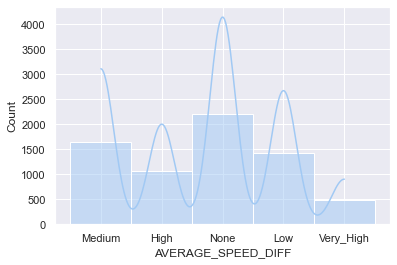

In [15]:
sns.histplot(traffic['AVERAGE_SPEED_DIFF'],kde=True)

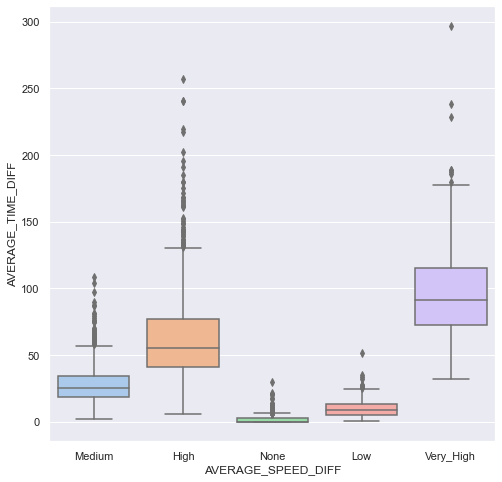

In [16]:
plt.subplots(figsize=(8,8))
ax = sns.boxplot(x=traffic["AVERAGE_SPEED_DIFF"], y=traffic["AVERAGE_TIME_DIFF"])

## FASE 1
**Tratamento dos dados**

### Remoção de colunas redundantes
- *city_name*, *AVERAGE_PRECIPITATION* é sempre o mesmo em todas as obvervações
- *AVERAGE_CLOUDINESS*
- *AVERAGE_RAIN* tem muitas observações com *missing data* (6249), ia acrescentar muito ruído.
- *AVERAGE_HUMIDITY* tem uma correlação forte com a *AVERAGE_TEMPERATURE*, e por isso era redundante para o modelo de previsão.  

In [17]:
traffic = traffic.drop(['city_name'], axis=1)
traffic = traffic.drop(['AVERAGE_PRECIPITATION'], axis=1)
traffic = traffic.drop(['AVERAGE_CLOUDINESS'], axis=1)
traffic = traffic.drop(['AVERAGE_RAIN'], axis=1)
traffic = traffic.drop(['AVERAGE_HUMIDITY'], axis=1)

test = test.drop(['city_name'], axis=1)
test = test.drop(['AVERAGE_PRECIPITATION'], axis=1)
test = test.drop(['AVERAGE_CLOUDINESS'], axis=1)
test = test.drop(['AVERAGE_RAIN'], axis=1)
test = test.drop(['AVERAGE_HUMIDITY'], axis=1)

### Transformação de valores categóricos
- O *AVERAGE_SPEED_DIFF* devemos passar para do tipo int (None = 0, Low = 1, Medium = 2, High = 3, Very_High = 4)
- a *LUMINOSITY* pode ser passada para o tipo int (Dark = 0, Low_Light = 1, Light = 2)

In [18]:
#tratamento de average_speed_diff, luminosity
traffic["AVERAGE_SPEED_DIFF"] = traffic['AVERAGE_SPEED_DIFF'].replace({'None' : 0, 'Low' : 1, 'Medium' : 2, 'High' : 3, 'Very_High' : 4}).astype(int)
traffic["LUMINOSITY"] = traffic['LUMINOSITY'].replace({'DARK' : 0, 'LOW_LIGHT' : 1, 'LIGHT' : 2}).astype(int)

test["LUMINOSITY"] = test['LUMINOSITY'].replace({'DARK' : 0, 'LOW_LIGHT' : 1, 'LIGHT' : 2}).astype(int)

### Criação de Features - Data da observação
- o record_date pode ser dividido em 3 colunas - hora, dia da semana e mes. 
    - O dia da semana é posteriormente transformado em números entre 0-6.

In [19]:
#transformação da data para datetime
traffic.record_date = pd.to_datetime(traffic.record_date)

test.record_date = pd.to_datetime(test.record_date)

In [20]:
#divisão da coluna record_date em 3 colunas diferentes
traffic['Month'] = traffic.record_date.dt.month
traffic['Hour'] = traffic.record_date.dt.hour 
traffic['Day'] = traffic.record_date.dt.day_name()
traffic['Day'] = traffic['Day'].replace({'Sunday' : 1, 'Monday' : 0, 'Tuesday' : 0, 'Wednesday' : 0, 'Thursday' : 0,'Friday' : 0,'Saturday' : 1}).astype(int)
traffic = traffic.drop(['record_date'], axis=1)

test['Month'] = test.record_date.dt.month
test['Hour'] = test.record_date.dt.hour
test['Day'] = test.record_date.dt.day_name()
test['Day'] = test['Day'].replace({'Sunday' : 1, 'Monday' : 0, 'Tuesday' : 0, 'Wednesday' : 0, 'Thursday' : 0,'Friday' : 0,'Saturday' : 1}).astype(int)
test = test.drop(['record_date'], axis=1)

In [21]:
def daypart(hour):
    if hour > 0 and hour <= 8:
        return "dawn"
    elif hour > 8 and hour <= 16:
        return "working_hour"
    else: return "midnight"

traffic['Day_Part'] = traffic['Hour'].apply(daypart)

#one hor encoding day part
one_hot_dates = pd.get_dummies(traffic['Day_Part'])
del traffic['Day_Part']
traffic = pd.concat([traffic, one_hot_dates], axis=1)

test['Day_Part'] = test['Hour'].apply(daypart)

#one hor encoding day part
one_hot_dates = pd.get_dummies(test['Day_Part'])
test = pd.concat([test, one_hot_dates], axis=1)
del test['Day_Part']


In [22]:
traffic

,AVERAGE_SPEED_DIFF,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,LUMINOSITY,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_WIND_SPEED,Month,Hour,Day,dawn,midnight,working_hour
0,2,41.5,11.5,71.4,2,15.0,1019.0,3.0,8,7,0,1,0,0
1,3,41.7,48.3,87.4,2,21.0,1021.0,5.0,8,14,0,0,0,1
2,3,38.6,38.4,85.2,2,26.0,1014.0,4.0,9,16,1,0,0,1
3,3,37.4,61.0,94.1,2,18.0,1025.0,4.0,2,11,0,0,0,1
4,2,41.6,50.4,77.0,2,15.0,1008.0,10.0,6,12,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6807,1,41.2,3.7,86.9,2,9.0,1030.0,4.0,2,9,1,0,0,1
6808,2,38.9,51.9,76.9,2,17.0,1020.0,6.0,6,18,1,0,1,0
6809,0,39.6,0.0,89.1,0,15.0,1020.0,4.0,10,4,0,1,0,0
6810,0,41.6,0.0,85.5,0,8.0,1018.0,1.0,1,1,0,1,0,0


In [23]:
test

,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,LUMINOSITY,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_WIND_SPEED,Month,Hour,Day,dawn,midnight,working_hour
0,39.2,0.0,91.0,0,8.0,1026.0,1.0,2,23,0,0,1,0
1,42.5,12.2,76.8,0,11.0,1020.0,4.0,11,20,0,0,1,0
2,45.9,0.0,86.3,0,14.0,1017.0,0.0,8,5,0,1,0,0
3,33.2,51.7,89.9,2,22.0,1016.0,4.0,7,17,1,0,1,0
4,44.0,3.5,85.5,0,12.0,1004.0,9.0,10,6,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,50.2,1.1,80.5,0,11.0,1013.0,5.0,11,5,1,1,0,0
1496,38.0,4.6,85.6,0,9.0,1028.0,0.0,3,2,0,1,0,0
1497,43.8,0.0,80.4,0,16.0,1013.0,1.0,9,1,0,1,0,0
1498,46.0,83.2,83.2,2,10.0,1004.0,5.0,11,8,0,1,0,0


### Tratamento dos *outliers*

In [24]:
traffic.AVERAGE_FREE_FLOW_TIME = winsorize(traffic['AVERAGE_FREE_FLOW_TIME'], limits=(0.01, 0.01))
traffic.AVERAGE_FREE_FLOW_SPEED = winsorize(traffic['AVERAGE_FREE_FLOW_SPEED'], limits=(0.05, 0.01))
traffic.AVERAGE_TEMPERATURE = winsorize(traffic['AVERAGE_TEMPERATURE'], limits=(0.01, 0.02))
traffic.AVERAGE_ATMOSP_PRESSURE = winsorize(traffic['AVERAGE_ATMOSP_PRESSURE'], limits=(0.05, 0.015))
traffic.AVERAGE_WIND_SPEED = winsorize(traffic['AVERAGE_WIND_SPEED'], limits=(0.01, 0.03))

test.AVERAGE_FREE_FLOW_TIME = winsorize(test['AVERAGE_FREE_FLOW_TIME'], limits=(0.01, 0.01))
test.AVERAGE_FREE_FLOW_SPEED = winsorize(test['AVERAGE_FREE_FLOW_SPEED'], limits=(0.05, 0.01))
test.AVERAGE_TEMPERATURE = winsorize(test['AVERAGE_TEMPERATURE'], limits=(0.01, 0.02))
test.AVERAGE_ATMOSP_PRESSURE = winsorize(test['AVERAGE_ATMOSP_PRESSURE'], limits=(0.05, 0.015))
test.AVERAGE_WIND_SPEED = winsorize(test['AVERAGE_WIND_SPEED'], limits=(0.01, 0.03))

In [25]:
def is_outlier(s): 
    lower_limit = s.mean() - (s.std() * 1)
    upper_limit = s.mean() + (s.std() * 1)
    return ~s.between(lower_limit, upper_limit)

#outliers = traffic.groupby('AVERAGE_SPEED_DIFF')['AVERAGE_TIME_DIFF'].apply(is_outlier) #v1
outliers = traffic['AVERAGE_TIME_DIFF'].transform(is_outlier) #v2

In [26]:
def is_outlier_test(s): 
    lower_limit = s.mean() - (s.std() * 1)
    upper_limit = s.mean() + (s.std() * 1)
    return ~s.between(lower_limit, upper_limit)

outliers_test = test['AVERAGE_TIME_DIFF'].transform(is_outlier)
outliers_test

0       False
1       False
2       False
3       False
4       False
        ...  
1495    False
1496    False
1497    False
1498     True
1499    False
Name: AVERAGE_TIME_DIFF, Length: 1500, dtype: bool

In [27]:
mask = outliers == True
traffic_outliers = traffic[mask] # dataset com outliers
traffic_s_outliers = traffic[~mask] # dataset sem outliers

In [28]:
mask1 = outliers_test == True
test_outliers = test[mask1] # dataset com outliers
test_s_outliers = test[~mask1] # dataset sem outliers

### Dataset Final

<AxesSubplot:>

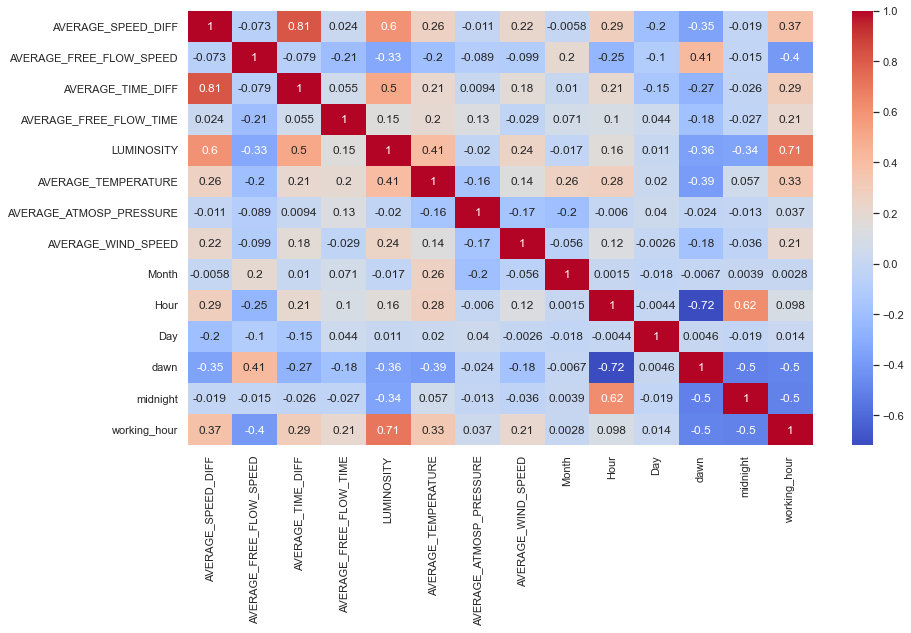

In [29]:
#matriz de correlação
plt.subplots(figsize=(14,8))
sns.heatmap(traffic.corr(), annot = True, cmap='coolwarm')

## FASE 2
**Criação do modelo**

In [30]:
x_s_out = traffic_s_outliers.drop(['AVERAGE_SPEED_DIFF'], axis=1)
y_s_out = traffic_s_outliers['AVERAGE_SPEED_DIFF'].to_frame()
x_s_out

,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,LUMINOSITY,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_WIND_SPEED,Month,Hour,Day,dawn,midnight,working_hour
0,41.5,11.5,71.4,2,15.0,1019.0,3.0,8,7,0,1,0,0
1,41.7,48.3,87.4,2,21.0,1021.0,5.0,8,14,0,0,0,1
2,38.6,38.4,85.2,2,26.0,1014.0,4.0,9,16,1,0,0,1
4,41.6,50.4,77.0,2,15.0,1008.0,8.0,6,12,0,0,0,1
5,50.5,5.6,68.5,1,13.0,1014.0,4.0,11,7,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6807,41.2,3.7,86.9,2,9.0,1030.0,4.0,2,9,1,0,0,1
6808,38.9,51.9,76.9,2,17.0,1020.0,6.0,6,18,1,0,1,0
6809,39.6,0.0,89.1,0,15.0,1020.0,4.0,10,4,0,1,0,0
6810,41.6,0.0,85.5,0,8.0,1018.0,1.0,1,1,0,1,0,0


In [31]:
x_c_out = traffic_outliers.drop(['AVERAGE_SPEED_DIFF'], axis=1)
y_c_out = traffic_outliers['AVERAGE_SPEED_DIFF'].to_frame()
x_c_out

,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,LUMINOSITY,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_WIND_SPEED,Month,Hour,Day,dawn,midnight,working_hour
3,37.4,61.0,94.1,2,18.0,1025.0,4.0,2,11,0,0,0,1
24,43.1,113.5,86.2,2,22.0,1011.0,7.0,8,18,0,0,1,0
27,34.0,136.9,93.6,2,20.0,1019.0,3.0,8,12,0,0,0,1
41,46.0,131.7,61.8,2,16.0,1015.0,3.0,6,8,0,1,0,0
44,42.9,63.6,85.6,2,20.0,1018.0,2.0,9,18,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6781,37.8,66.7,70.4,2,28.0,1020.0,6.0,5,15,1,0,0,1
6783,40.7,106.0,81.6,2,21.0,1021.0,2.0,9,16,0,0,0,1
6794,48.1,87.9,76.2,2,11.0,1025.0,6.0,2,8,0,1,0,0
6797,40.5,74.2,78.0,0,8.0,1018.0,3.0,1,18,0,0,1,0


In [32]:
X_semOutliers = x_s_out.to_numpy()
Y_semOutliers = y_s_out.to_numpy()

In [33]:
X_comOutliers = x_c_out.to_numpy()
Y_comOutliers = y_c_out.to_numpy()

In [34]:
X_testComOutliers = test_outliers.to_numpy()
X_testSemOutliers = test_s_outliers.to_numpy()

### MODELOS

In [35]:
# SEM OUTLIERS
cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
# define the model
model = RandomForestClassifier(random_state=2021)
# define search space
space = dict()
space['n_estimators'] = [10, 100, 500]
space['max_features'] = [2, 4, 6]
space['criterion'] = ['gini', 'entropy']
# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)
result = search.fit(X_semOutliers,np.ravel(Y_semOutliers))
best_model = result.best_estimator_
predictions_semOutliers = best_model.predict(X_testSemOutliers)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# execute the nested cross-validation
scores = cross_val_score(search, X_semOutliers, Y_semOutliers, scoring='accuracy', cv=cv_outer, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
predictions_nested_semOutliers  = pd.DataFrame(predictions_semOutliers, columns = ["Speed_Diff"])
print(predictions_nested_semOutliers)

Accuracy: 0.801 (0.013)
      Speed_Diff
0              0
1              2
2              0
3              3
4              1
...          ...
1293           3
1294           1
1295           0
1296           0
1297           1

[1298 rows x 1 columns]


In [ ]:
# COM OUTLIERS
cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
# define the model
model = RandomForestClassifier(random_state=1)
# define search space
space = dict()
space['n_estimators'] = [10, 100, 500]
space['max_features'] = [2, 4, 6]
space['criterion'] = ['gini', 'entropy']
# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)
result = search.fit(X_comOutliers,np.ravel(Y_comOutliers))
best_model = result.best_estimator_
predictions_outliers = best_model.predict(X_testComOutliers)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# execute the nested cross-validation
scores = cross_val_score(search, X_comOutliers, Y_comOutliers, scoring='accuracy', cv=cv_outer, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
predictions_nested_comOutliers  = pd.DataFrame(predictions_outliers, columns = ["Speed_Diff"])
print(predictions_nested_comOutliers)

In [ ]:
test_outliers["Speed_Diff"] = predictions_outliers.tolist()
test_outliers

In [ ]:
test_s_outliers["Speed_Diff"] = predictions_semOutliers.tolist()
test_s_outliers

In [ ]:
pred = pd.concat([test_outliers,test_s_outliers])
pred

In [ ]:
pred = pred.sort_index()

In [ ]:
pred = pred['Speed_Diff'].to_numpy()
pred

## FASE 3
**Passagem dos valores para ficheiro CSV**

In [ ]:
'''
# acrescentar headers

submission = pd.DataFrame(pred, columns = ["Speed_Diff"])
submission.insert(0, "RowId", range(1,1501), True)

#transformação dos valores para formato escrito
submission['Speed_Diff']= submission['Speed_Diff'].replace({0 : 'None', 1 : 'Low', 2 : 'Medium', 3 : 'High', 4 : 'Very_High'})

#passagem para ficheiro csv
submission.to_csv('sub28_NCV_HourDividida_comHour.csv', index=False)

submission
'''
